# Homework 07: Expectation-Maximization Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as spa
from scipy.stats import multivariate_normal

## Importing Data Set

In [2]:
X = np.genfromtxt("hw07_data_set.csv", delimiter=',')
centroids = np.genfromtxt("hw07_initial_centroids.csv", delimiter=',')

In [3]:
N = len(X)
K = 5

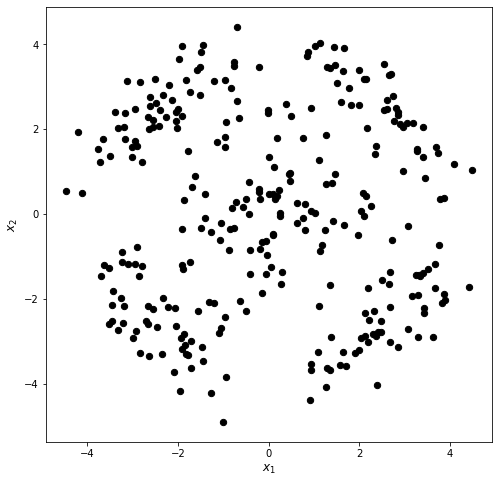

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=40, color="k")

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.show()

## Algorithm Steps

### Initialization

In [5]:
def initial_memberships(centroids, X):
    D = spa.distance_matrix(centroids, X)
    memberships = np.argmin(D, axis = 0)
    return(memberships)

def initial_covariance_matrices(memberships, centroids, X, K):
    covariance_matrices = [np.sum([(X[memberships == k][i] - centroids[k]).reshape(2, 1) @ (X[memberships == k][i] - centroids[k]).reshape(1, 2)for i in range(len(X[memberships == k]))], axis=0) / len(X[memberships == k]) for k in range(5)]
    return(covariance_matrices)

def initial_prior_probabilities(memberships, X, N):
    prior_probabilities = np.array(pd.Series(memberships).value_counts().sort_index()/N)
    return(prior_probabilities)

In [6]:
memberships = initial_memberships(centroids, X)
covariance_matrices = initial_covariance_matrices(memberships, centroids, X, K)
prior_probabilities = initial_prior_probabilities(memberships, X, N)

In [7]:
print(f"Initial Centroids (Mean Vectors):\n{centroids}\n")
print(f"Initial Memberships:\n{memberships}\n")
print(f"Membership Value Counts:\n{pd.Series(memberships).value_counts()}\n")
print(f"Initial Covariance Matrices:\n{covariance_matrices}\n")
print(f"Initial Prior Probabilities:\n{prior_probabilities}")

Initial Centroids (Mean Vectors):
[[-3.0439416   0.32509753]
 [-0.30377397  3.73480678]
 [ 1.17587258 -2.50984601]
 [ 0.91037084  0.87608158]
 [-1.98588337  2.98466811]]

Initial Memberships:
[1 3 3 1 3 3 3 3 3 3 3 3 1 1 1 3 3 3 3 3 3 1 3 3 3 3 3 1 3 3 3 3 1 1 3 1 1
 1 1 3 3 3 1 3 1 1 3 3 1 3 4 4 4 4 4 1 1 4 4 0 4 4 0 0 4 0 0 1 4 0 0 4 4 4
 4 4 4 4 0 4 4 1 0 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 0 0 2 0 2 0 0 2 2 0 0 0
 0 2 2 0 0 2 0 2 0 0 0 0 0 0 2 0 0 2 2 0 0 2 0 0 0 2 0 0 0 0 2 2 2 2 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 4 2 3 0 2 3 0 0 4 2 3 2 1 3 3 3 0 3 2 2
 2 2 3 2 0 3 3 2 2 3 3 3 3 0 3 3 3 3 1 3 0 0 3 3 3 3 4 3 2 3 3 3 0 3 3 3 3
 3 1 3 3 4 3 2 3 3 4 2 0 3 2 3 0 3 2 0 3 0 0 3 3 3 0 4 3 3 3 4 2 3 1 3 3 3
 3 3 3 1]

Membership Value Counts:
3    89
2    85
0    58
4    42
1    26
dtype: int64

Initial Covariance Matrices:
[array([[ 0.80960599, -0.46324747],
       [-0.46324747,  3.80320539]]), array([[ 2.33101

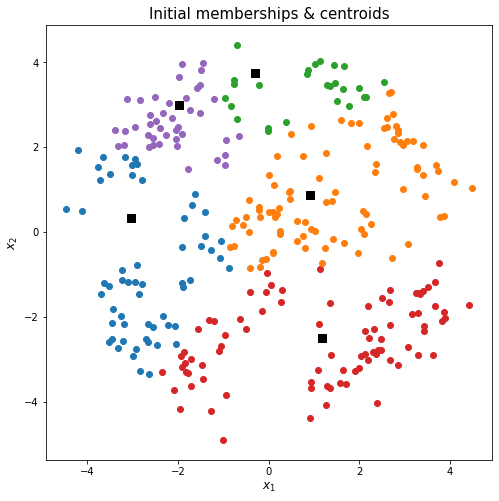

In [8]:
colors = ["C0", "C2", "C3", "C1", "C4"]

plt.figure(figsize=(8, 8))

plt.title("Initial memberships & centroids", fontsize=15)

for i in range(5):
    plt.scatter(X[memberships == i][:, 0], X[memberships == i][:, 1], color=colors[i])
    plt.scatter(centroids[i][0], centroids[i][1], color="k", marker="s", s=50)

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.show()

## Expectation-Maximization (EM) Algorithm

**loglikelihood:** $L(\Phi|X) = \log\left[\prod_{i=1}^N p(x_i|\Phi)\right]$

$\mathcal{L}(\Phi|X) = \sum_{i=1}^N\left[\sum_{k=1}^N p(x_i|C_k)P(C_k)\right]$

Two sets of random variables:
- $Z = $ cluster memberships (hidden variables)
- $\Phi =$ parameters $[\hat{\mu_1}, \hat{\mu_2}, ..., \hat{\mu_k}, \hat{\Sigma_1}, \hat{\Sigma_2}, ..., \hat{\Sigma_k}]$

**E-STEP:** $E\left[L_c(\Phi|X, Z) | X, \Phi^{(t)}\right]$

**M-STEP:** $\Phi^{t+1} = argmax E\left[L_c(\Phi|X, Z)|X, \Phi^{(t)}\right]$

### Update Equations:

**E-STEP:**

$h_{ik} = E\left[z_{ik}|X, \Phi^{(t)}\right] = \frac{p(x_i|C_k, \Phi^{(t)})P(C_k)}{\sum_{c=1}^K p(x_i|C_c, \Phi^{(t)})P(C_c)}$

**M-STEP:**

$\hat{\mu}_k^{(t+1)} = \frac{\sum_{i=1}^N h_{ik}x_i}{\sum_{i=1}^N h_{ik}}$

$\hat{\sigma}_k^{(t+1)} = \frac{\sum_{i=1}^N h_{ik}(x_i - \hat{\mu}_k^{(t+1)})(x_i - \hat{\mu}_k^{(t+1)})^T}{\sum_{i=1}^N h_{ik}}$

$\hat{P}(C_K) = \frac{\sum_{i=1}^N h_{ik}}{N}$

In [9]:
def multivariate_gaussian(x, mean, covariance):
    return (1. / (np.sqrt((2 * np.pi)**2 * np.linalg.det(covariance))) *  np.exp(-(np.linalg.solve(covariance, x - mean).T.dot(x - mean)) / 2))
def mixture_density(x, mean, covariance, prior_probability):
    return multivariate_gaussian(x, mean, covariance) * prior_probability
def h_ik(x, centroids, covariance_matrices, prior_probabilities):
    return [mixture_density(x, centroids[k], covariance_matrices[k], prior_probabilities[k]) / np.sum([mixture_density(x, centroids[i], covariance_matrices[i], prior_probabilities[i]) for i in range(K)]) for k in range(K)]

### E-Step

In [10]:
def find_memberships(X, centroids, covariance_matrices, prior_probabilities):
    memberships = []

    for m in range(N):
        posterior_probabilities = h_ik(X[m], centroids, covariance_matrices, prior_probabilities)
        max_value = max(posterior_probabilities)
        max_index = posterior_probabilities.index(max_value)
        memberships.append(max_index)
    return np.array((memberships))

### M-Step

In [11]:
def update_centroids(memberships, X):
    return np.vstack([np.sum([h_ik(X[memberships == k][i], centroids, covariance_matrices, prior_probabilities)[k] * X[memberships == k][i] for i in range(len(X[memberships == k]))], axis=0) / len(X[memberships == k]) for k in range(K)])

def update_covariance_matrices(memberships, centroids, X, K):
    return [np.sum([h_ik(X[memberships == k][i], centroids, covariance_matrices, prior_probabilities)[k] * (X[memberships == k][i] - centroids[k]).reshape(2, 1) @ (X[memberships == k][i] - centroids[k]).reshape(1, 2) for i in range(len(X[memberships == k]))], axis=0) / len(X[memberships == k]) for k in range(K)]
    
def update_prior_probabilities(memberships, X, N):
    return np.array(pd.Series(memberships).value_counts().sort_index()/N)

## Running EM Algorithm

Iteration#:1


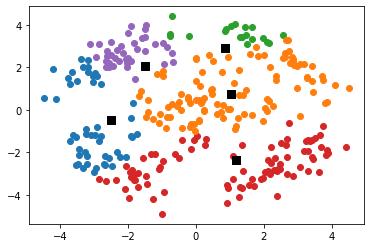

Iteration#:2


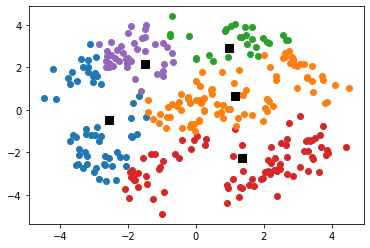

Iteration#:3


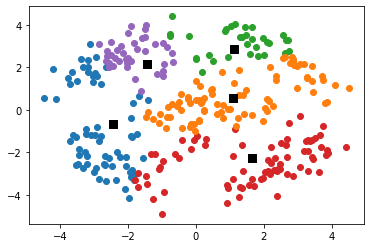

Iteration#:4


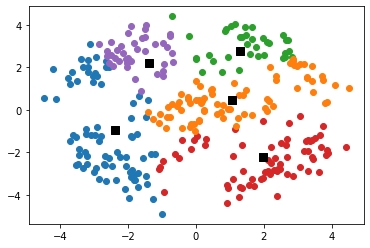

Iteration#:5


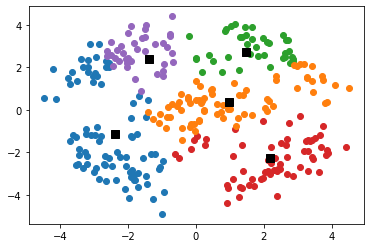

Iteration#:6


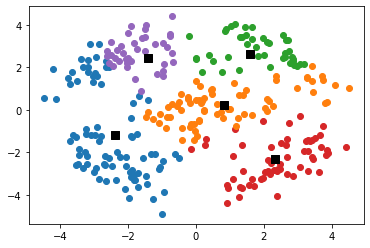

Iteration#:7


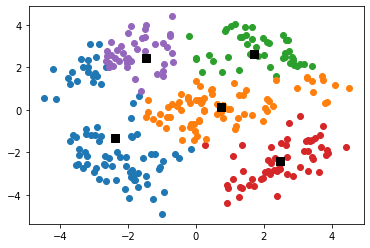

Iteration#:8


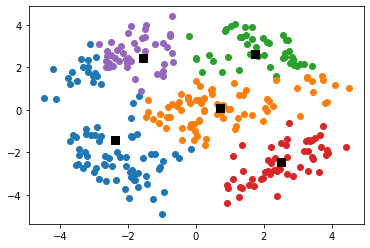

Iteration#:9


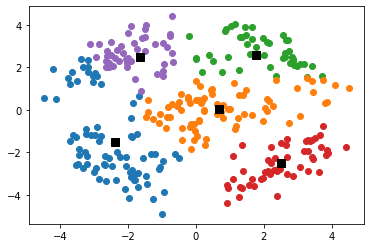

Iteration#:10


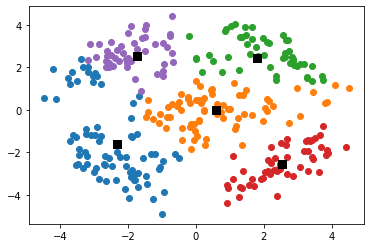

Iteration#:11


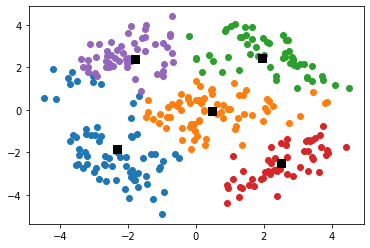

Iteration#:12


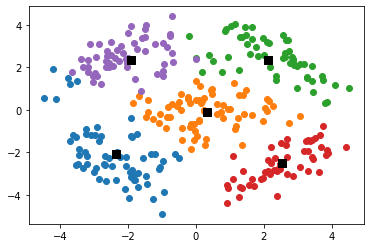

Iteration#:13


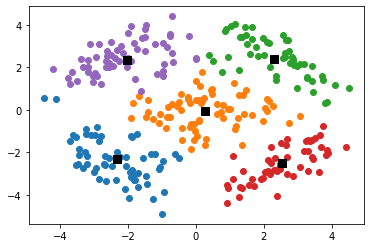

Iteration#:14


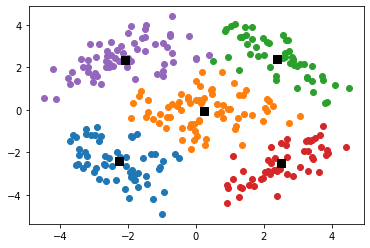

Iteration#:15


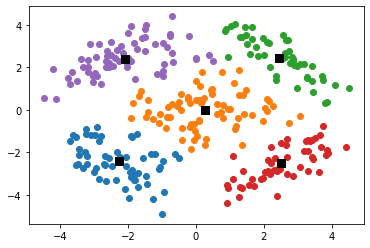

Iteration#:16


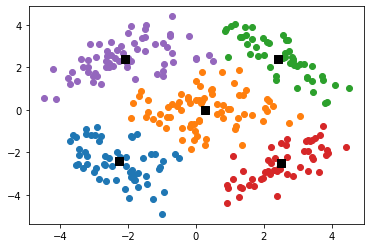

Iteration#:17


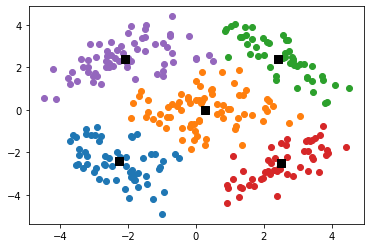

Iteration#:18


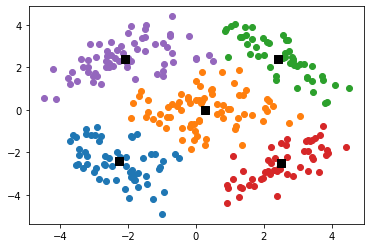

Iteration#:19


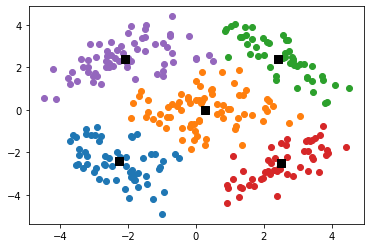

Iteration#:20


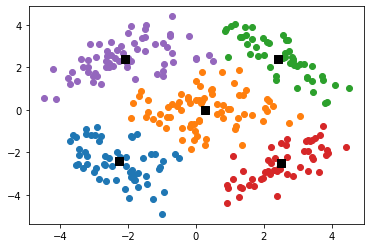

Iteration#:21


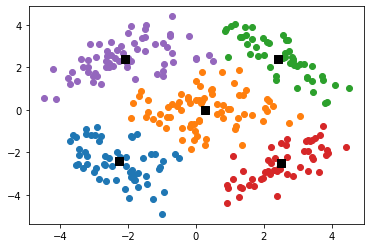

Iteration#:22


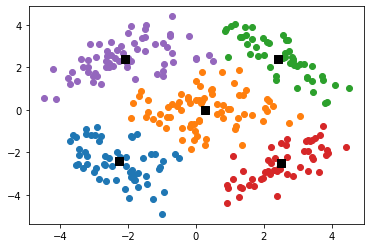

Iteration#:23


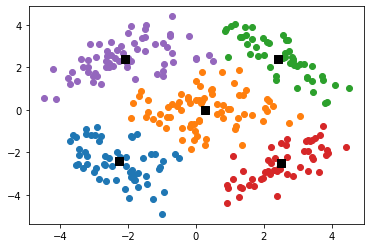

Iteration#:24


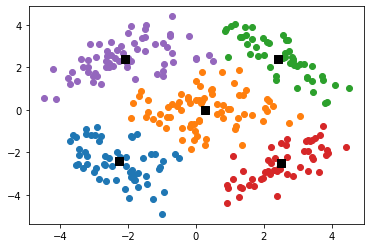

Iteration#:25


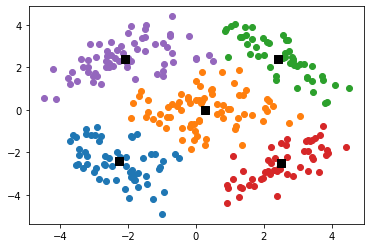

Iteration#:26


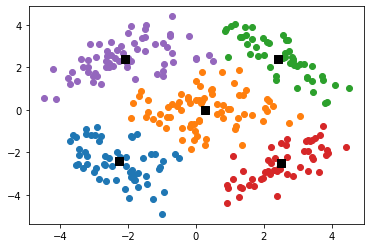

Iteration#:27


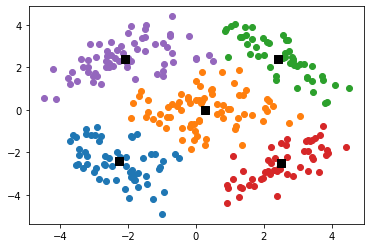

Iteration#:28


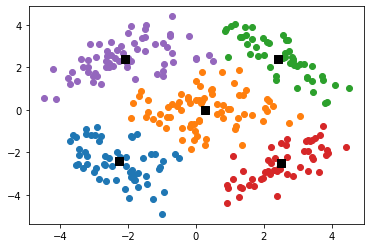

Iteration#:29


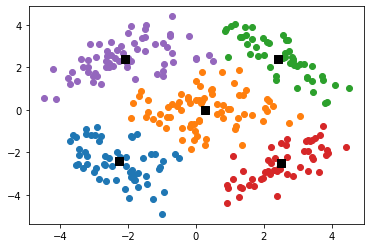

Iteration#:30


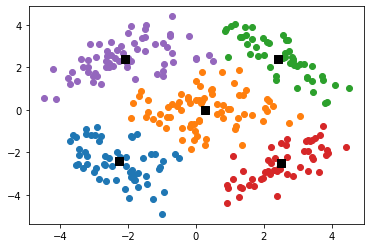

Iteration#:31


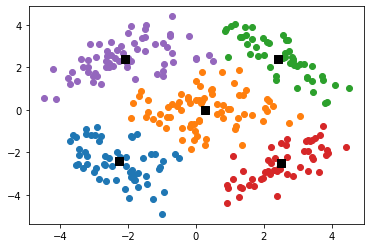

Iteration#:32


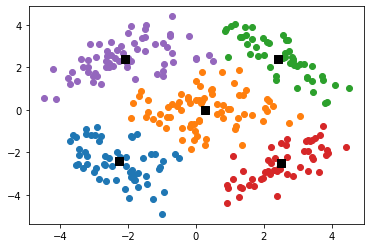

Iteration#:33


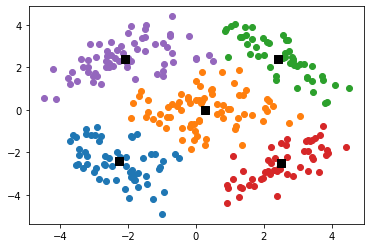

Iteration#:34


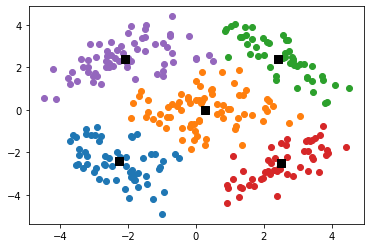

Iteration#:35


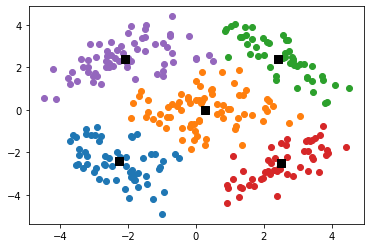

Iteration#:36


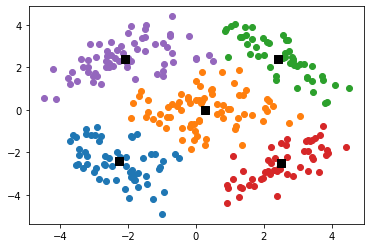

Iteration#:37


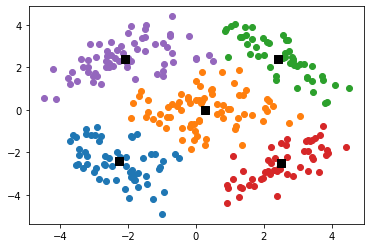

Iteration#:38


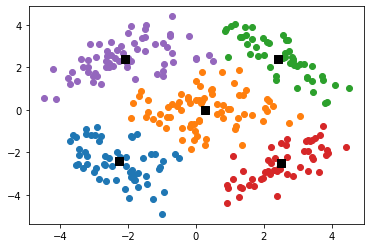

Iteration#:39


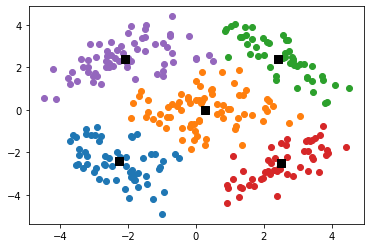

Iteration#:40


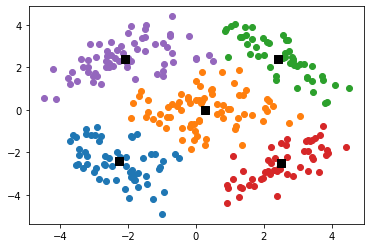

Iteration#:41


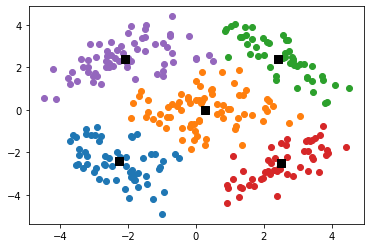

Iteration#:42


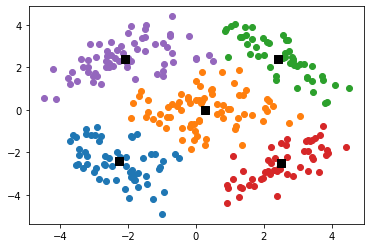

Iteration#:43


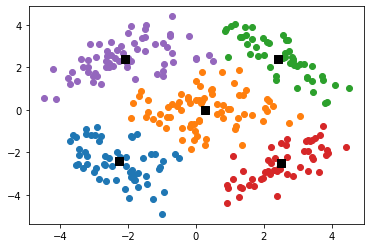

Iteration#:44


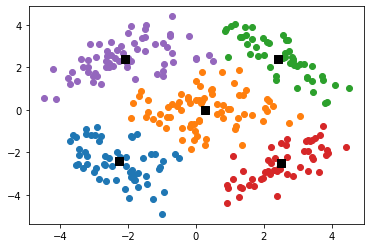

Iteration#:45


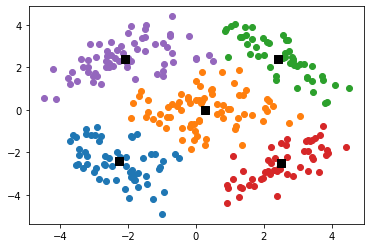

Iteration#:46


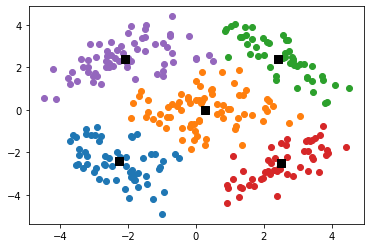

Iteration#:47


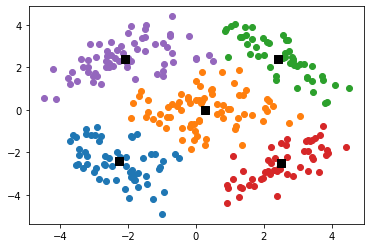

Iteration#:48


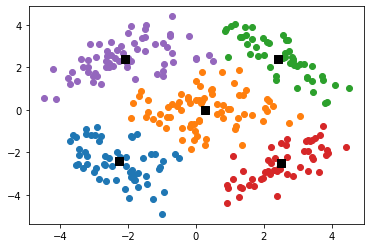

Iteration#:49


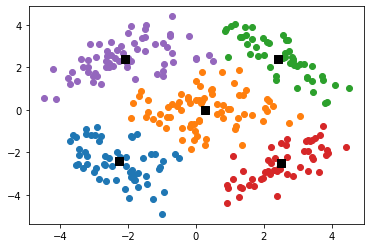

Iteration#:50


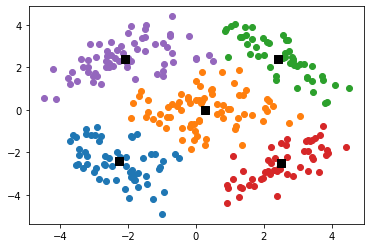

Iteration#:51


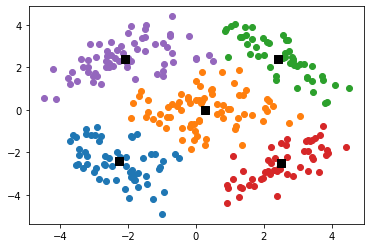

Iteration#:52


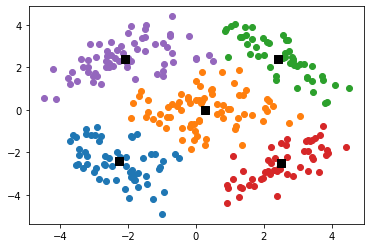

Iteration#:53


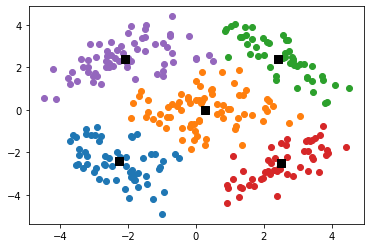

Iteration#:54


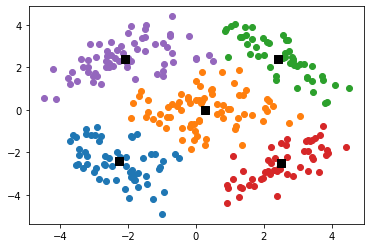

Iteration#:55


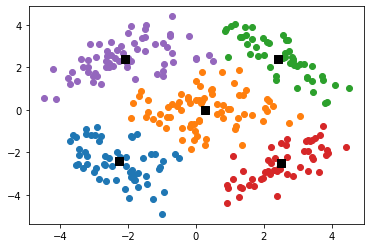

Iteration#:56


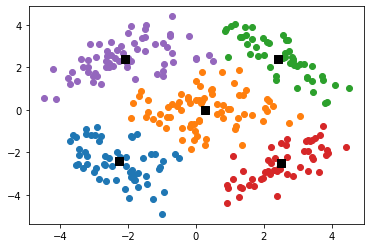

Iteration#:57


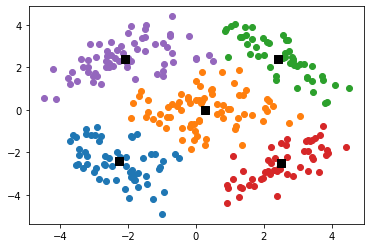

Iteration#:58


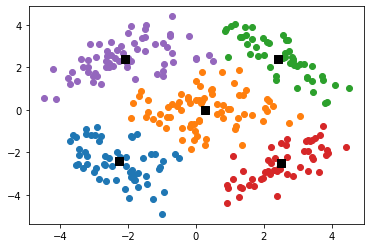

Iteration#:59


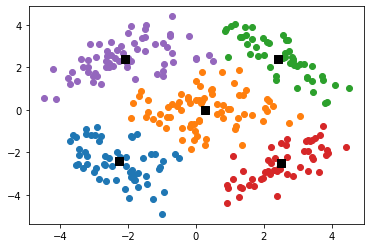

Iteration#:60


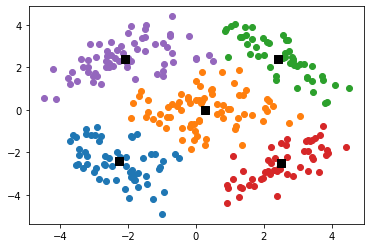

Iteration#:61


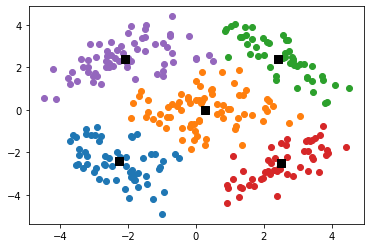

Iteration#:62


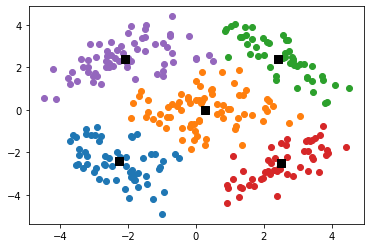

Iteration#:63


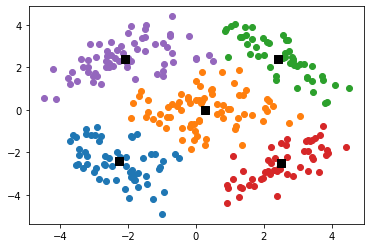

Iteration#:64


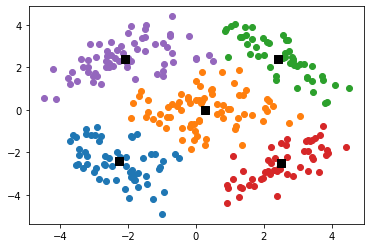

Iteration#:65


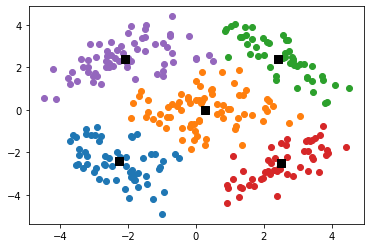

Iteration#:66


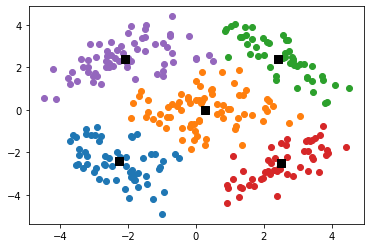

Iteration#:67


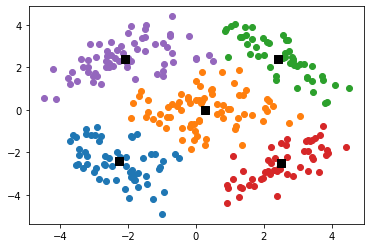

Iteration#:68


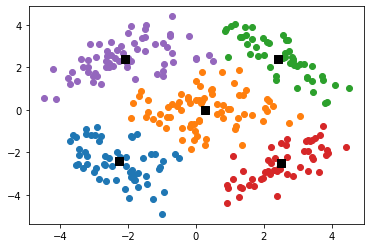

Iteration#:69


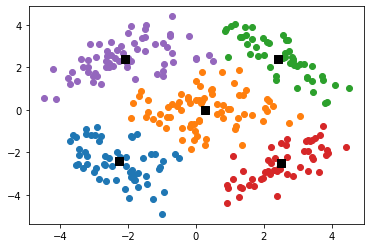

Iteration#:70


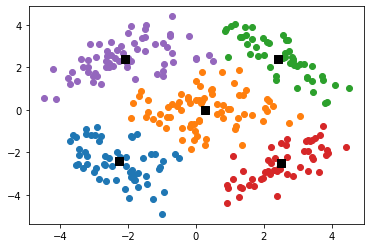

Iteration#:71


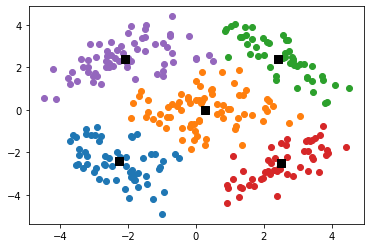

Iteration#:72


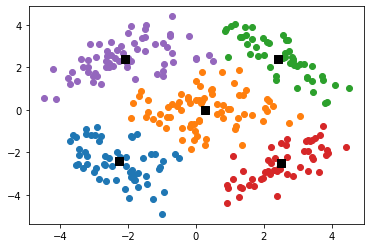

Iteration#:73


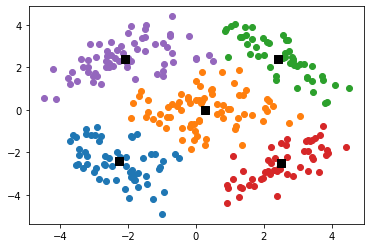

Iteration#:74


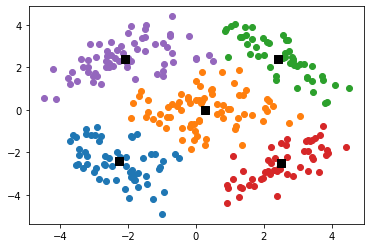

Iteration#:75


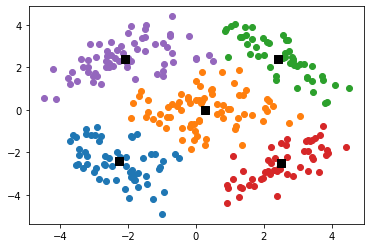

Iteration#:76


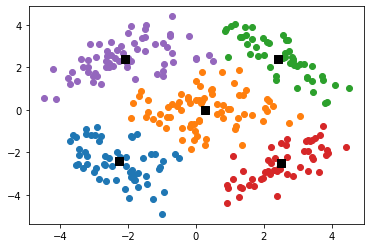

Iteration#:77


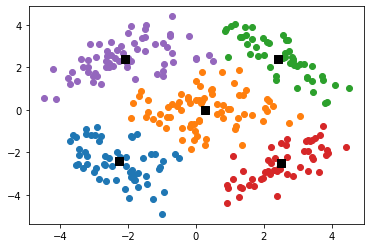

Iteration#:78


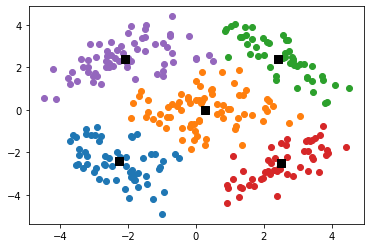

Iteration#:79


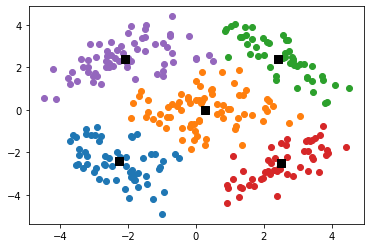

Iteration#:80


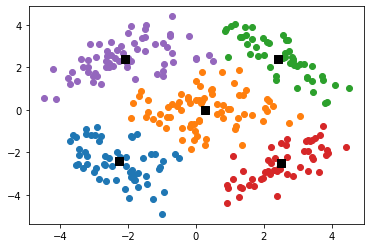

Iteration#:81


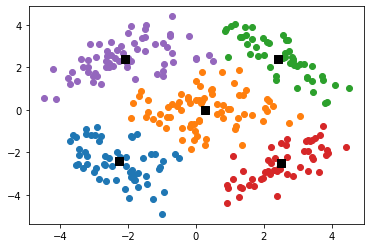

Iteration#:82


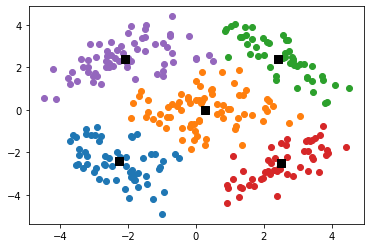

Iteration#:83


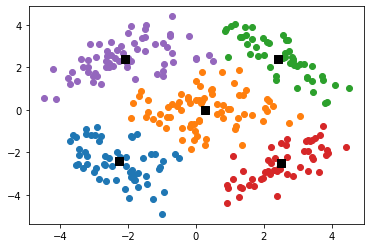

Iteration#:84


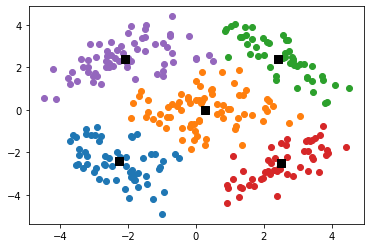

Iteration#:85


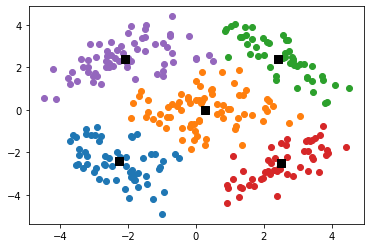

Iteration#:86


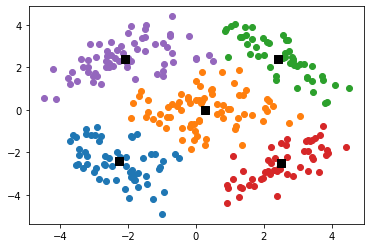

Iteration#:87


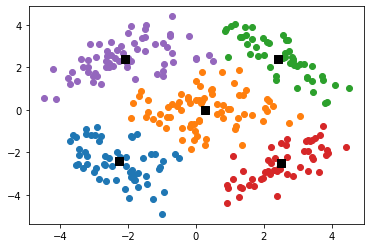

Iteration#:88


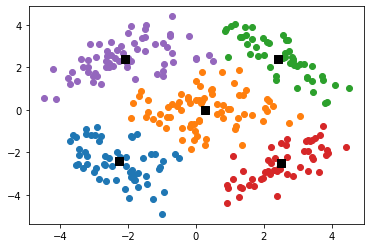

Iteration#:89


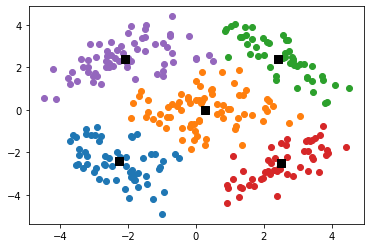

Iteration#:90


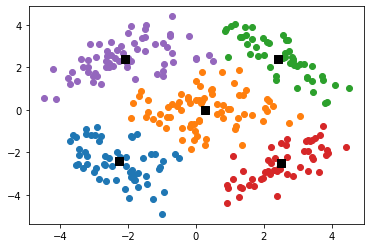

Iteration#:91


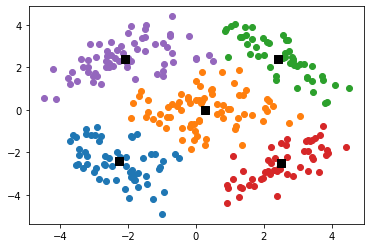

Iteration#:92


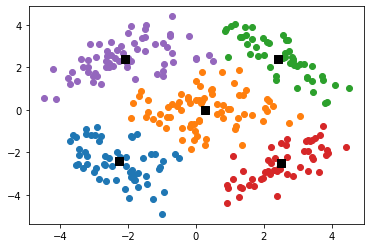

Iteration#:93


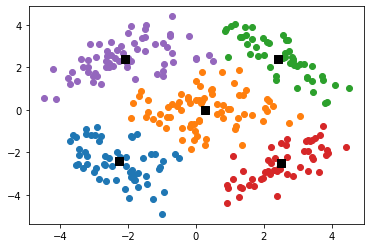

Iteration#:94


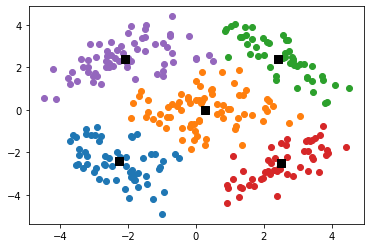

Iteration#:95


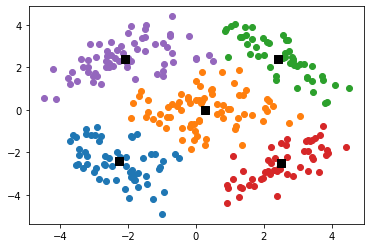

Iteration#:96


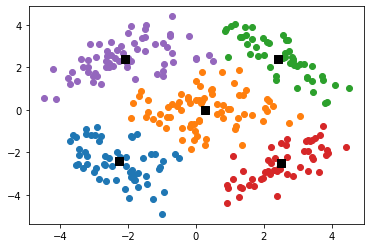

Iteration#:97


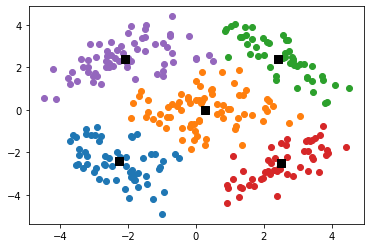

Iteration#:98


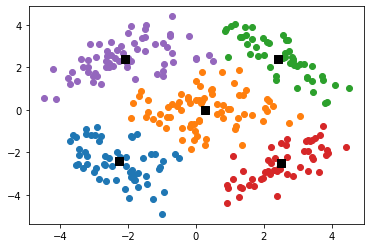

Iteration#:99


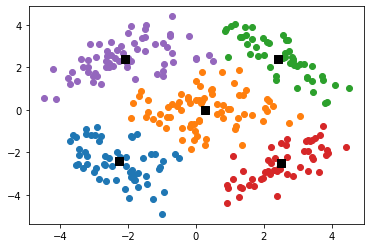

Iteration#:100


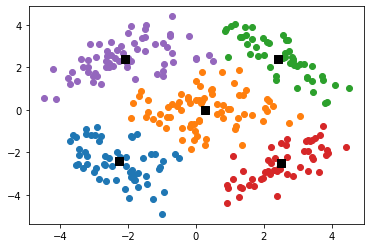

In [12]:
for iteration in range(100):
    memberships = find_memberships(X, centroids, covariance_matrices, prior_probabilities)
    centroids = update_centroids(memberships, X)
    covariance_matrices = update_covariance_matrices(memberships, centroids, X, K)
    prior_probabilities = update_prior_probabilities(memberships, X, N)

    
    print(f"Iteration#:{iteration+1}")

    for i in range(5):
        plt.scatter(X[memberships == i][:, 0], X[memberships == i][:, 1], color=colors[i])
        plt.scatter(centroids[i][0], centroids[i][1], color="k", marker="s", s=50)
    plt.show()

In [13]:
print(f"Mean vectors after 100 iterations:\n\n{centroids}")

Mean vectors after 100 iterations:

[[-2.25320393 -2.40773298]
 [ 2.42091488  2.40690293]
 [ 2.51541881 -2.5153351 ]
 [ 0.26442888 -0.00693325]
 [-2.07993059  2.38274832]]


## Visualization

In [14]:
initial_means = np.array([[+2.5, +2.5],
                          [-2.5, +2.5],
                          [-2.5, -2.5],
                          [+2.5, -2.5],
                          [+0.0, -0.0]])

initial_covariances = np.array([[[+0.8, -0.6], [-0.6, +0.8]],
                                [[+0.8, +0.6], [+0.6, +0.8]],
                                [[+0.8, -0.6], [-0.6, +0.8]],
                                [[+0.8, +0.6], [+0.6, +0.8]],
                                [[+1.6, +0.0], [+0.0, +1.6]]])

x, y = np.mgrid[-6:+6:.05, -6:+6:.05]
pos = np.dstack((x, y))

original_gausses = [multivariate_normal(mean=initial_means[i], cov=initial_covariances[i]*2) for i in range(5)]
found_gausses = [multivariate_normal(mean=centroids[i], cov=covariance_matrices[i]*2) for i in range(5)]

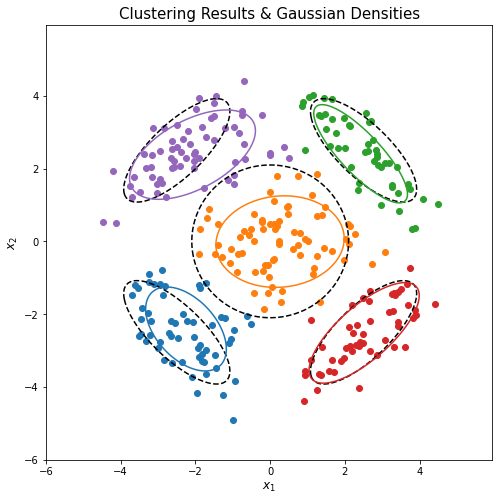

In [15]:
plt.figure(figsize=(8, 8))

plt.title("Clustering Results & Gaussian Densities", fontsize=15)

for original_gauss in original_gausses:
    plt.contour(x, y, original_gauss.pdf(pos), levels=1, linestyles="dashed", colors="k")
for i, found_gauss in enumerate(found_gausses):
    plt.contour(x, y, found_gauss.pdf(pos), levels=1, colors=colors[i])
for i in range(5):
    plt.scatter(X[memberships == i][:, 0], X[memberships == i][:, 1], color=colors[i])
    
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.show()